In [35]:
import math
import json
import random
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from scipy import stats

In [96]:
#given a polymorphism frequency, return bin
def frequency_binning(x, midfreq_high, midfreq_low):
    #nan frequencies are when there is no sequence coverage at the given position
    if math.isnan(x):
        f_bin = float('nan')
    else:
        if x == 1.0:
            f_bin = 'f'
        elif x>=midfreq_high:
            f_bin = 'h'
        elif x<midfreq_high and x>=midfreq_low:
            f_bin = 'm'
        elif x<midfreq_low:
            f_bin='l'

    return f_bin

In [37]:
def walk_through_sites(outgroup_seq, outgroup_aa_seq, alignment_seqs, midfreq_high, midfreq_low):
    
    #at each site, count number of viruses with polymorphism
    count_polymorphic = np.zeros(len(outgroup_seq))
    #at each site, count totaly number of viruses
    count_total_unambiguous = np.zeros(len(outgroup_seq))
    
    count_replacement_mutations = np.zeros(len(outgroup_seq))
    count_silent_mutations = np.zeros(len(outgroup_seq))
    
    #at each site, list of nucleotide from each virus
    ingroup_bases = [[] for x in range(len(outgroup_seq))]
       
    for seq in alignment_seqs:
        if len(seq) != len(outgroup_seq):
            print(seq)
        elif len(seq) == len(outgroup_seq):                   
            for pos in range(len(outgroup_seq)):
                outgroup_nt = str(outgroup_seq[pos])
                virus_nt = str(seq[pos])
                #skip ambiguous sites
                if virus_nt != 'N':
                    if outgroup_nt != 'N':
                        ingroup_bases[pos].append(virus_nt)
                        count_total_unambiguous[pos]+=1
                        if virus_nt != outgroup_nt:
                            count_polymorphic[pos]+=1
                            #determine silent or replacement
                            codon = math.floor(pos/3)
                            codon_pos = pos-(codon*3)
                            if codon_pos == 0:
                                codon_nt = virus_nt+outgroup_seq[pos+1:(pos+3)]
                            elif codon_pos == 1:
                                codon_nt = outgroup_seq[pos-1]+virus_nt+outgroup_seq[pos+1]
                            elif codon_pos == 2:
                                codon_nt = outgroup_seq[(pos-2):(pos)]+virus_nt

                                
                            if isinstance(codon_nt, str):
                                codon_nt = Seq(codon_nt)

                            codon_aa = codon_nt.translate()
                            
                            outgroup_aa = outgroup_aa_seq[codon]
                            if outgroup_aa != 'X':
                                if codon_aa != outgroup_aa:
                                    count_replacement_mutations[pos]+=1
                                elif codon_aa == outgroup_aa:
                                    count_silent_mutations[pos]+=1
                                
    polymorphic_frequencies = count_polymorphic/count_total_unambiguous
    
    replacement_score = count_replacement_mutations/count_total_unambiguous

    freq_bins = [frequency_binning(x, midfreq_high, midfreq_low) for x in polymorphic_frequencies]
    
    return freq_bins, replacement_score, ingroup_bases

In [38]:
def determine_site_type(outgroup, ingroup):
    ingroup_bases_nan = set(ingroup)
    #remove 'nan's
    ingroup_bases = {x for x in ingroup_bases_nan if pd.notna(x)}
    
    
    if len(ingroup_bases) == 0:
        site_type = None
    
    elif len(ingroup_bases) != 0:
        #all ingroup bases are identical
        if len(ingroup_bases) == 1:
            if outgroup in ingroup_bases:
                site_type = 1
            elif outgroup not in ingroup_bases:
                site_type = 2

        #2 different bases in ingroup
        elif len(ingroup_bases) == 2:
            if outgroup in ingroup_bases:
                site_type = 3
            elif outgroup not in ingroup_bases:
                site_type = 4

        #3 different bases in ingroup
        elif len(ingroup_bases) == 3:
            if outgroup in ingroup_bases:
                site_type = 5
            elif outgroup not in ingroup_bases:
                site_type = 6

        #4 different bases in ingroup
        elif len(ingroup_bases) == 4:
            site_type = 7
    
    return site_type

In [39]:
def fixation_polymorphism_score(outgroup, ingroup):
    site_type = determine_site_type(outgroup, ingroup)

    
    if site_type == None:
        Fi = float('nan')
        Pi = float('nan')
    if site_type == 1:
        Fi = 0
        Pi = 0
    elif site_type == 2:
        Fi = 1
        Pi = 0
    elif site_type in [3,5,7]:
        Fi = 0
        Pi = 1
    elif site_type == 4:
        Fi = 0.5
        Pi = 0.5
    elif site_type == 6:
        Fi = (1/3)
        Pi = (2/3)
    
    return Fi, Pi

In [40]:
def assign_fi_pi(outgroup_seq, ingroup_bases):
    
    #at each site, record Fi
    Fi_all = np.zeros(len(outgroup_seq))
    
    #at each site, record Pi
    Pi_all = np.zeros(len(outgroup_seq))
    
    for pos in range(len(outgroup_seq)):
        outgroup_nt = outgroup_seq[pos]
        ingroup_nts = ingroup_bases[pos]
        Fi, Pi = fixation_polymorphism_score(outgroup_nt, ingroup_nts)
        Fi_all[pos] = Fi
        Pi_all[pos] = Pi
        
    return Fi_all, Pi_all
    
    
                            

In [41]:
def make_s1_s2_alignments(scheme):
    s1_alignment_path = '../santa-sim_oc43a/santa-sim_oc43a-s1/results/aligned_'+str(scheme)+'.fasta'
    s2_alignment_path = '../santa-sim_oc43a/santa-sim_oc43a-s2/results/aligned_'+str(scheme)+'.fasta'
    
    if path.exists(s1_alignment_path):
        pass
    else:
        spike_alignment_path = '../santa-sim_oc43a/santa-sim_oc43a-spike/results/aligned_'+str(scheme)+'.fasta'
        s1_sequences = []
        s2_sequences = []
        with open(spike_alignment_path, "r") as aligned_handle:
            for virus in SeqIO.parse(aligned_handle, "fasta"):
                #coordinates are for oc43 spike
                s1_seq = virus.seq[39:2298]
                s2_seq = virus.seq[2298:]
                
                s1_sequences.append(SeqRecord(s1_seq, id=virus.id, description=virus.description))
                s2_sequences.append(SeqRecord(s2_seq, id=virus.id, description=virus.description))
                
        SeqIO.write(s1_sequences, s1_alignment_path, "fasta")
        SeqIO.write(s2_sequences, s2_alignment_path, "fasta")
                
                

In [42]:
def subset_viruses(scheme, gene, window, min_seqs, year_max=None, year_min= None):

    #Make S1 and S2 alignments from Spike
    if gene == 's1' or gene == 's2':
        make_s1_s2_alignments(scheme)

    input_file_alignment = '../santa-sim_oc43a/santa-sim_oc43a-'+str(gene)+'/results/aligned_'+str(scheme)+'.fasta'
    
    if gene == 's1' or gene == 's2':
        metafile = '../santa-sim_oc43a/santa-sim_oc43a-spike/results/metadata_'+str(scheme)+'.tsv'
    else:
        metafile = '../santa-sim_oc43a/santa-sim_oc43a-'+str(gene)+'/results/metadata_'+str(scheme)+'.tsv'
    

    
    
    #Subset data based on time windows
    meta = pd.read_csv(metafile, sep = '\t')
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)
    
    date_range = meta['year'].max() - meta['year'].min()
    
    
    
    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            
            #non-overlapping
#             date_window_end += window
#             date_window_start+= window
            
            #sliding window
            date_window_end += 1
            date_window_start += 1 
    
    #Only use time points with enough data:
    virus_time_subset = {k:v for k,v in virus_time_subset.items() if len(v)>=min_seqs}


    year_windows = []
    seqs_in_window = []
    
    #Find outgroup sequence from strains at first time point(to make consensus from)
    first_window = True
    first_window_strains = []
    first_window_sequences = []
    
    alignment_time_subset = {}
    
    
    for years, subset_viruses in virus_time_subset.items():
        year_windows.append(years)
        seqs_in_window.append(len(subset_viruses))
        alignment_time_subset[years] = []

        #make consensus sequence at first time point
        if first_window == True:
            first_window_strains+=subset_viruses
            first_window = False

        with open(input_file_alignment, "r") as aligned_handle:
            for virus in SeqIO.parse(aligned_handle, "fasta"):
                if virus.id in first_window_strains:
                    first_window_sequences.append(virus)
                if virus.id in subset_viruses:
                    alignment_time_subset[years].append(virus.seq)


    first_window_alignment = MultipleSeqAlignment(first_window_sequences)
    outgroup_seq = AlignInfo.SummaryInfo(first_window_alignment).dumb_consensus(ambiguous ='N')
    outgroup_aa_seq = outgroup_seq.translate()

    
    return virus_time_subset, alignment_time_subset, outgroup_seq, outgroup_aa_seq, year_windows, seqs_in_window 
    

In [43]:
#for each time point, create sample alignment of same size as emperical alignment
def bootstrap_alignment(bootstrap_codon_order, sequences):
    
    bootstrap_alignment_seqs = []
    for virus_seq in sequences:
        virus_seq_str = str(virus_seq)
        virus_codons = [virus_seq_str[i:i+3] for i in range(0, len(virus_seq_str), 3)] 
        bootstrap_virus = ''.join([virus_codons[x] for x in bootstrap_codon_order])
        bootstrap_alignment_seqs.append(bootstrap_virus)
    
    return bootstrap_alignment_seqs

In [44]:
#sample codons from emperical ancestral sequence with replacement
def bootstrap_ancestral(outgroup_seq):
    outgroup_seq_str = str(outgroup_seq)
    #sample codons with replacement
    ancestral_codons = [outgroup_seq_str[i:i+3] for i in range(0, len(outgroup_seq_str), 3)] 
    bootstrap_codon_order = random.choices(range(len(ancestral_codons)), k=len(ancestral_codons))
    bootstrap_ancestral_seq = ''.join([ancestral_codons[x] for x in bootstrap_codon_order])
    bootstrap_ancestral_seq = Seq(bootstrap_ancestral_seq)
    return bootstrap_ancestral_seq, bootstrap_codon_order


In [45]:
def make_bootstrap_dataset(outgroup_seq, alignment_time_subset):
            
    bootstrap_ancestral_seq, bootstrap_codon_order = bootstrap_ancestral(outgroup_seq)
    bootstrap_ancestral_seq_aa = bootstrap_ancestral_seq.translate()
    
    bootstrap_alignment_seqs = {}
    for years, sequences in alignment_time_subset.items():
        bootstrap_sequences = bootstrap_alignment(bootstrap_codon_order, sequences)
        bootstrap_alignment_seqs[years] = bootstrap_sequences

        
    return bootstrap_ancestral_seq, bootstrap_ancestral_seq_aa, bootstrap_alignment_seqs

In [97]:
def calc_site_stats(alignment_sequences, outgroup_seq, outgroup_aa_seq, midfreq_high, midfreq_low):
    
    #Find percent polymorphism at each site
    #Also determine whether polymorphism is silent or replacement  
    

    #initiate lists to record all time windows
    frequency_bins = []
    fixation_scores = []
    polymorphism_scores = []
    replacement_scores = []
    silent_scores = []    
        

    for years, alignment_seqs in alignment_sequences.items():
  
        #calculate stats for each window separately
        freq_bins, replacement_score, ingroup_bases = walk_through_sites(outgroup_seq, outgroup_aa_seq, 
                                                                         alignment_seqs,
                                                                         midfreq_high, midfreq_low)
        Fi_all, Pi_all = assign_fi_pi(outgroup_seq, ingroup_bases)
        silent_score = 1-replacement_score

        frequency_bins.append(freq_bins)
        fixation_scores.append(Fi_all)
        polymorphism_scores.append(Pi_all)
        replacement_scores.append(replacement_score)
        silent_scores.append(silent_score)
            
            

    return frequency_bins, fixation_scores, polymorphism_scores, replacement_scores, silent_scores
            
            


In [47]:
#M=rm/sm 
#not expected to vary through time provided that long-term effective population sizes remain sufficiently large
#For each gene, calculate M by combining site count among time points

def calc_m_ratio(scheme, gene, window, min_seqs, midfreq_high, midfreq_low, bootstrap, year_max=None, year_min= None):
    if gene=='spike' or gene=='s1':
        (virus_time_subset, alignment_time_subset, 
         outgroup_seq, outgroup_aa_seq, 
         year_windows, seqs_in_window) = subset_viruses(scheme, 's2', 'all', 
                                                        min_seqs, year_max, year_min)
        if bootstrap:
            input_file_alignment = '../santa-sim_oc43a/santa-sim_oc43a-'+str(gene)+'/results/aligned_'+str(scheme)+'.fasta'
            (bootstrap_ancestral_seq, bootstrap_ancestral_seq_aa,
             bootstrap_alignment_seqs) = make_bootstrap_dataset(outgroup_seq, alignment_time_subset)
        
        
    else:
        (virus_time_subset, alignment_time_subset, 
         outgroup_seq, outgroup_aa_seq, 
         year_windows, seqs_in_window) = subset_viruses(scheme, gene, 'all', 
                                                        min_seqs, year_max, year_min)
        if bootstrap:
            input_file_alignment = '../santa-sim_oc43a/santa-sim_oc43a-'+str(gene)+'/results/aligned_'+str(scheme)+'.fasta'
            (bootstrap_ancestral_seq, bootstrap_ancestral_seq_aa,
             bootstrap_alignment_seqs) = make_bootstrap_dataset(outgroup_seq, alignment_time_subset)
    
    if bootstrap:
            (frequency_bins, 
             fixation_scores, polymorphism_scores, 
             replacement_scores, silent_scores) = calc_site_stats(bootstrap_alignment_seqs, 
                                                                  bootstrap_ancestral_seq, bootstrap_ancestral_seq_aa, 
                                                                  midfreq_high, midfreq_low)
    else:
        (frequency_bins, 
         fixation_scores, polymorphism_scores, 
         replacement_scores, silent_scores) = calc_site_stats(alignment_time_subset, 
                                                              outgroup_seq, outgroup_aa_seq, midfreq_high, midfreq_low)
        
    
    sm = 0
    rm = 0
    
    for site in range(len(frequency_bins[0])):
        freq_bin = frequency_bins[0][site]
        if freq_bin == 'm':
            sm+= (polymorphism_scores[0][site]*silent_scores[0][site])
            rm+= (polymorphism_scores[0][site]*replacement_scores[0][site])
    
    if sm ==0:
        sm = 0.00000000000000001
    m_ratio = rm/sm
    
    return m_ratio

In [101]:
def bhatt_estimators(gene, outgroup_seq, frequency_bins, year_windows, fixation_scores, polymorphism_scores, replacement_scores, silent_scores, m_ratio):

    
    #Initiate lists to store a values
    window_midpoint = []
    adaptive_substitutions = []
    
    #for each window, calculate bhatt estimators 
    for years_window in range(len(frequency_bins)):
        window_start = int(year_windows[years_window][0:4])
        window_end = int(year_windows[years_window][-4:])
        window_midpoint.append((window_start + window_end)/2)

        sf = 0
        rf = 0
        sh = 0
        rh = 0
        sm = 0
        rm = 0
        sl = 0
        rl = 0

        #calculate number of sites in different catagories (defined by polymorphic freq at that site)
        window_freq_bins = frequency_bins[years_window]
        for site in range(len(window_freq_bins)):
            freq_bin = window_freq_bins[site]
            #ignore sites with no polymorphisms?
            if freq_bin!='nan':
                if freq_bin == 'f':
                    sf+= (fixation_scores[years_window][site]*silent_scores[years_window][site])
                    rf+= (fixation_scores[years_window][site]*replacement_scores[years_window][site])
                elif freq_bin == 'h':
                    sh+= (polymorphism_scores[years_window][site]*silent_scores[years_window][site])
                    rh+= (polymorphism_scores[years_window][site]*replacement_scores[years_window][site])
                elif freq_bin == 'm':
                    sm+= (polymorphism_scores[years_window][site]*silent_scores[years_window][site])
                    rm+= (polymorphism_scores[years_window][site]*replacement_scores[years_window][site])
                elif freq_bin == 'l':
                    sl+= (polymorphism_scores[years_window][site]*silent_scores[years_window][site])
                    rl+= (polymorphism_scores[years_window][site]*replacement_scores[years_window][site])       

#             print(year_windows[years_window])
#             print(sf, rf, sh, rh, sm, rm, sl, rl)  

        #Calculate equation 1: number of nonneutral sites
        al = rl - sl*m_ratio
        ah = rh - sh*m_ratio
        af = rf - sf*m_ratio
        #set negative a values to zero
        if al < 0:
            al = 0
        if ah < 0:
            ah = 0
        if af < 0:
            af = 0

#         print(al, ah, af)

        #Calculate the number and proportion of all fixed or high-freq sites that have undergone adaptive change
        number_adaptive_substitutions = af + ah
        adaptive_substitutions.append(number_adaptive_substitutions)
#         proportion_adaptive_sites = (af + ah)/(rf +rh)

    
    gene_length = len(outgroup_seq)
    adaptive_substitutions_per_codon = [x/gene_length for x in adaptive_substitutions]
    
    if len(window_midpoint)!=0:
        rate_of_adaptation, intercept, r_value, p_value, std_err = stats.linregress(window_midpoint, adaptive_substitutions_per_codon)
    else:
        rate_of_adaptation = 0
            
    return window_midpoint, adaptive_substitutions, adaptive_substitutions_per_codon, rate_of_adaptation
        

In [88]:
def calc_bhatt_a(scheme, gene, window=3, min_seqs=3, midfreq_high=0.75, midfreq_low=0.15, bootstrap= False, year_max=None, year_min=None):
    #Get virus subset
    (virus_time_subset, alignment_time_subset, 
     outgroup_seq, outgroup_aa_seq, year_windows, seqs_in_window) = subset_viruses(scheme, gene, 
                                                                                   window, min_seqs, 
                                                                                   year_max=None, year_min= None)
#     print(alignment_time_subset, [len(alignment_time_subset[x]) for x in alignment_time_subset.keys()], seqs_in_window)
    #Calculate frequencies for emperical data
    (frequency_bins, 
     fixation_scores, polymorphism_scores, 
     replacement_scores, silent_scores) = calc_site_stats(alignment_time_subset, outgroup_seq, 
                                                          outgroup_aa_seq, midfreq_high, midfreq_low)
    
    
    #calculate m ratio
    m_ratio = calc_m_ratio(scheme, gene, window, 
                           min_seqs, midfreq_high, midfreq_low, False, 
                           year_max, year_min)
    
    
    #calculate bhatt estimators
    (window_midpoint, adaptive_substitutions, 
     adaptive_substitutions_per_codon, rate_of_adaptation) = bhatt_estimators(gene, outgroup_seq, 
                                                                              frequency_bins, year_windows, 
                                                                              fixation_scores, polymorphism_scores, 
                                                                              replacement_scores, silent_scores, m_ratio)
    
    
    n_bootstraps = 100
    bootstrap_count = 0
    
    bootstrap_adaptive_substitutions = []
    bootstrap_adaptive_substitutions_per_codon = []
    bootstrap_rate_of_adaptation = []
    if bootstrap:
        while bootstrap_count < n_bootstraps:
            bootstrap_count+=1
            #Get bootstrapped ancestral seq and alignment
            (bootstrap_ancestral_seq, bootstrap_ancestral_seq_aa,
             bootstrap_alignment_seqs) = make_bootstrap_dataset(outgroup_seq, alignment_time_subset)


            #Calculate frequencies for bootstrap data
            (bootstrap_frequency_bins, 
             bootstrap_fixation_scores, bootstrap_polymorphism_scores, 
             bootstrap_replacement_scores, bootstrap_silent_scores) = calc_site_stats(bootstrap_alignment_seqs, 
                                                                                      bootstrap_ancestral_seq, 
                                                                                      bootstrap_ancestral_seq_aa, 
                                                                                      midfreq_high, midfreq_low)
            #Calculate m ratio
            bootstrap_m_ratio = calc_m_ratio(scheme, gene, window, 
                                             min_seqs, midfreq_high, midfreq_low, True,  
                                             year_max, year_min)

            #calculate bhatt estimators
            (bs_window_midpoint, bs_adaptive_substitutions, 
             bs_adaptive_substitutions_per_codon, 
             bs_rate_of_adaptation) = bhatt_estimators(gene, bootstrap_ancestral_seq, 
                                                              bootstrap_frequency_bins, year_windows, 
                                                              bootstrap_fixation_scores, 
                                                              bootstrap_polymorphism_scores, 
                                                              bootstrap_replacement_scores, bootstrap_silent_scores, 
                                                              bootstrap_m_ratio)
            #add these bootstrap values to list
            bootstrap_adaptive_substitutions.append(bs_adaptive_substitutions)
            bootstrap_adaptive_substitutions_per_codon.append(bs_adaptive_substitutions_per_codon)
            bootstrap_rate_of_adaptation.append(bs_rate_of_adaptation)
    
    if bootstrap:
        return window_midpoint, adaptive_substitutions, adaptive_substitutions_per_codon, rate_of_adaptation, bootstrap_adaptive_substitutions, bootstrap_adaptive_substitutions_per_codon, bootstrap_rate_of_adaptation

    else:
        return window_midpoint, adaptive_substitutions, adaptive_substitutions_per_codon, rate_of_adaptation


In [52]:
def plot_adaptive_subs_per_codon(scheme, genes, window, min_seqs, midfreq_high=0.75, midfreq_low=0.15, bootstrap=False, year_max=None, year_min=None, filename=None):
    
    data_to_plot = []
    
    color_map = {'empirical':'#2E86C1'}
    
    for gene in genes:
        if bootstrap:
            save_json_name = 'bhatt_results/simulated/'+str(scheme)+'_'+str(gene)+'_bhatt_analysis_bootstrapped.json'
            if path.exists(save_json_name):
                with open(save_json_name) as json_handle:
                    json_dict = json.load(json_handle)
                    (window_midpoint, adaptive_substitutions, 
                     adaptive_substitutions_per_codon, 
                     rate_of_adaptation, bootstrap_adaptive_substitutions, 
                     bootstrap_adaptive_substitutions_per_codon, 
                     bootstrap_rate_of_adaptation) = (json_dict['window_midpoint'], 
                                                      json_dict['adaptive_substitutions'], 
                                                      json_dict['adaptive_substitutions_per_codon'], 
                                                      json_dict['rate_of_adaptation'], 
                                                      json_dict['bootstrap_adaptive_substitutions'], 
                                                      json_dict['bootstrap_adaptive_substitutions_per_codon'], 
                                                      json_dict['bootstrap_rate_of_adaptation'])

            else:

                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation, bootstrap_adaptive_substitutions, 
                 bootstrap_adaptive_substitutions_per_codon, 
                 bootstrap_rate_of_adaptation) = calc_bhatt_a(scheme, gene, window, 
                                                              min_seqs, midfreq_high, 
                                                              midfreq_low, bootstrap, year_max, year_min)

                save_json = {'scheme': scheme, 'gene': gene, 'window':window, 'min_seqs': min_seqs, 
                             'midfreq_high': midfreq_high, 'midfreq_low': midfreq_low,
                             'window_midpoint':window_midpoint, 'adaptive_substitutions':adaptive_substitutions, 
                             'adaptive_substitutions_per_codon':adaptive_substitutions_per_codon, 'rate_of_adaptation': rate_of_adaptation,
                             'bootstrap_adaptive_substitutions': bootstrap_adaptive_substitutions, 
                             'bootstrap_adaptive_substitutions_per_codon': bootstrap_adaptive_substitutions_per_codon, 
                             'bootstrap_rate_of_adaptation':bootstrap_rate_of_adaptation}
                with open(save_json_name, 'w') as outfile:
                    json.dump(save_json, outfile)
        else:
            save_json_name = 'bhatt_results/simulated/'+str(scheme)+'_'+str(gene)+'_bhatt_analysis.json'
            if path.exists(save_json_name):
                with open(save_json_name) as json_handle:
                    json_dict = json.load(json_handle)
                    (window_midpoint, adaptive_substitutions, 
                     adaptive_substitutions_per_codon, 
                     rate_of_adaptation) = (json_dict['window_midpoint'], 
                                            json_dict['adaptive_substitutions'], 
                                            json_dict['adaptive_substitutions_per_codon'], 
                                            json_dict['rate_of_adaptation'])


            else:
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation) = calc_bhatt_a(scheme, gene, window, min_seqs, 
                                                    midfreq_high, midfreq_low, 
                                                    bootstrap, year_max, year_min)

                save_json = {'scheme': scheme, 'gene': gene, 'window':window, 'min_seqs': min_seqs, 
                             'midfreq_high': midfreq_high, 'midfreq_low': midfreq_low,
                             'window_midpoint':window_midpoint, 'adaptive_substitutions':adaptive_substitutions, 
                             'adaptive_substitutions_per_codon':adaptive_substitutions_per_codon, 
                             'rate_of_adaptation': rate_of_adaptation}
                with open(save_json_name, 'w') as outfile:
                    json.dump(save_json, outfile)
        
        for year in range(len(window_midpoint)):
            data_to_plot.append({'scheme': scheme, 'gene': gene, 'data_plotted': 'empirical',
                                 'year': window_midpoint[year], 
                                 'adaptive_subs_per_codon': adaptive_substitutions_per_codon[year]})
            if bootstrap:
                num_bootstraps = range(len(bootstrap_adaptive_substitutions_per_codon))
                for bootstrap_iteration in num_bootstraps:
                    bs_adaptive_subs = 'bs_subs_'+str(bootstrap_iteration)
                    color_map['bs'+str(bootstrap_iteration)] = '#E5E5E5'
                    data_to_plot.append({'virus': virus, 'gene': gene, 'data_plotted': 'bs'+str(bootstrap_iteration),
                                         'year': window_midpoint[year], 
                                         bs_adaptive_subs: bootstrap_adaptive_substitutions_per_codon[bootstrap_iteration][year]})
        
    df_to_plot = pd.DataFrame(data_to_plot)
    
    
    sns.set(font_scale=2.0)
    sns.set_style("white")
    
    
    g = sns.FacetGrid(df_to_plot, col='gene', col_wrap=2, hue='data_plotted', height=6, aspect=1,
                      palette=color_map, sharey=True, sharex=False)
    

    #plot distribution of bootstrap regression lines
    if bootstrap:
        for bootstrap_iteration in num_bootstraps:
            g = g.map(sns.regplot, 'year', 'bs_subs_'+str(bootstrap_iteration), ci = None, scatter=False)
            
        backgroundartists = []
        for ax in g.axes.flat:
            for l in ax.lines + ax.collections:
                l.set_zorder(1)
                backgroundartists.append(l)

    #plot emprical data with regression line
    g = g.map(sns.regplot, 'year', 'adaptive_subs_per_codon', ci=None)
    
    if bootstrap:
        for ax in g.axes.flat:
            for l in ax.lines + ax.collections:
                if l not in backgroundartists:
                    l.set_zorder(5)
    
    #plot error bars
#     g = g.map(sns.pointplot, 'year', 'bs_adaptive_subs_per_codon', ci = 95, color='grey', join=False, capsize=.2)
    
    
    if filename:
        g.savefig(filename)
    
    
    

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


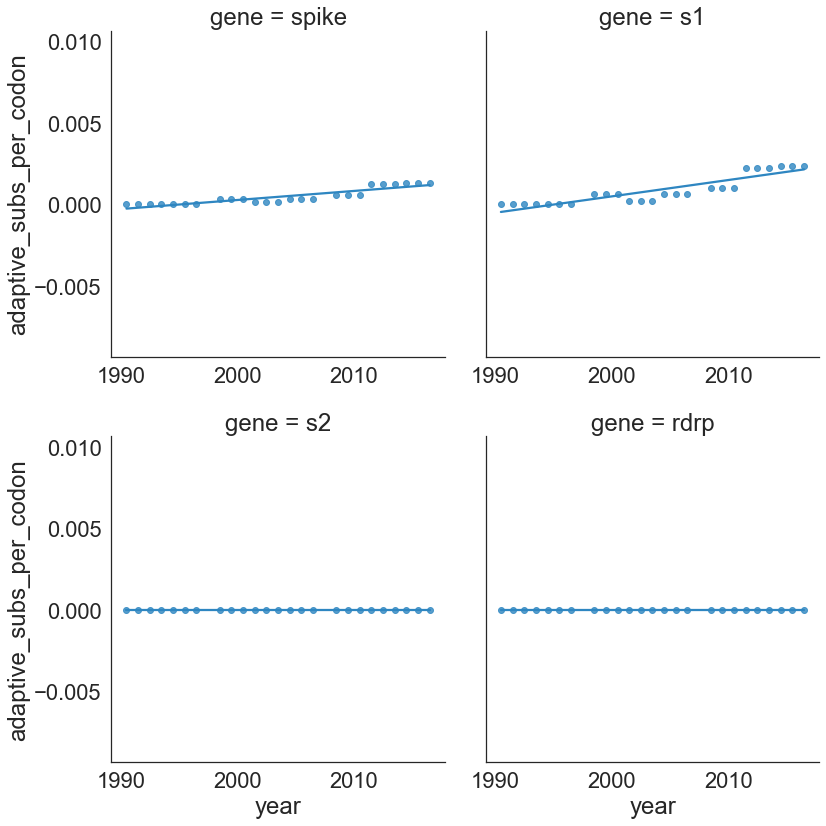

In [55]:
plot_adaptive_subs_per_codon('s1', ['spike', 's1', 's2', 'rdrp'], 3, 3)

In [146]:
#calculated as slope of adaptive subs per codon
def plot_adaptive_subs_per_codon_per_year_slope(schemes, genes, window=3, min_seqs=3, midfreq_high=0.75, midfreq_low=0.15, bootstrap=False, year_max=None, year_min=None, filename=None):
    
#     rdrp_scheme_map = {'r1':'r1', 'r2':'r1', 'r3':'r1', 'r4':'r1', 
#                        'r5':'r5', 'r6':'r5', 'r7':'r5', 'r8':'r5', 
#                        'r9':'r9', 'r10':'r9', 'r11':'r9', 'r12':'r9', 
#                        'r13':'r13', 'r14':'r13', 'r15':'r13', 'r16':'r13'}
    
    rdrp_scheme_map = {'1':'1', '2':'1', '3':'1', '4':'1', 
                   '5':'5', '6':'5', '7':'5', '8':'5', 
                   '9':'9', '10':'9', '11':'9', '12':'9', 
                   '13':'13', '14':'13', '15':'13', '16':'13'}
    
    data_to_plot = []


    for scheme in schemes:

        for gene in genes:
            if gene == 'rdrp':
                simulation_scheme = scheme[0]+str(rdrp_scheme_map[scheme[1:]])
            else:
                simulation_scheme = scheme

            save_json_name = 'bhatt_results/simulated/'+str(scheme)+'_'+str(gene)+'_bhatt_analysis.json'
            if path.exists(save_json_name):
                with open(save_json_name) as json_handle:
                    json_dict = json.load(json_handle)
                    (window_midpoint, adaptive_substitutions, 
                     adaptive_substitutions_per_codon, 
                     rate_of_adaptation) = (json_dict['window_midpoint'], 
                                            json_dict['adaptive_substitutions'], 
                                            json_dict['adaptive_substitutions_per_codon'], 
                                            json_dict['rate_of_adaptation'])
            else:
                (window_midpoint, adaptive_substitutions, 
                 adaptive_substitutions_per_codon, 
                 rate_of_adaptation) = calc_bhatt_a(simulation_scheme, gene, window, min_seqs, 
                                                    midfreq_high, midfreq_low, 
                                                    bootstrap, year_max, year_min)
                save_json = {'scheme': scheme, 'gene': gene, 'window':window, 'min_seqs': min_seqs, 
                             'midfreq_high': midfreq_high, 'midfreq_low': midfreq_low,
                             'window_midpoint':window_midpoint, 'adaptive_substitutions':adaptive_substitutions, 
                             'adaptive_substitutions_per_codon':adaptive_substitutions_per_codon, 
                             'rate_of_adaptation': rate_of_adaptation}
                with open(save_json_name, 'w') as outfile:
                    json.dump(save_json, outfile)
                    
            slope_sci = rate_of_adaptation * (10**3)
            data_to_plot.append({'scheme': scheme, 'gene': gene, 
             'adaptive_subs_per_codon_per_year': slope_sci})
                
            

                
        
    df_to_plot = pd.DataFrame(data_to_plot)
    
    sns.set(font_scale=1.0)
    sns.set_style("white")
    
    color_map = {'1': '#eab3ae', '2':'#da7b71',  '3': '#CB4335', '4': '#79281f', 
                 '5': '#ffe0b2', '6': '#ffc266', '7': '#ff9a00', '8': '#cc7b00', 
                 '9': '#cfe8ae', '10':'#abd771', '11':'#87c735', '12':'#5e8b25', 
                 '13':'#abcee6', '14':'#6caad3', '15':'#2e86c1', '16':'#205d87'}
    
    recomb_labels = {'1':'No Recombination', '5':'\nLow Recombination', 
                     '9':'\nModerate Recombination', '13':'\nHigh Recombination'}
    
    sel_labels = {1:'No Pos Selection', 2:'Low Pos Selection', 
                  3:'Moderate Pos Selection', 0:'High Pos Selection'}
    
    schemes = list(df_to_plot['scheme'].unique())
    
    x_coords = {}
    
    all_x_ticks = []
    last_coord = 0.0
    for gene in genes:
        x_coords[gene] = {}
        for scheme in schemes:
            last_coord+=0.25
            x_coords[gene][scheme] = last_coord
            all_x_ticks.append(last_coord)
        last_coord+=1.0
    
    fig, ax = plt.subplots(figsize=(15,8))
    
    x_labels = []
    gene_ticks = []
    
    for gene in genes:
        gene_coords = list(x_coords[gene].values())
        gene_ticks.append(sum(gene_coords)/len(gene_coords))
        x_labels.append(gene)
        for scheme in schemes:
            x = x_coords[gene][scheme]
            df_row = df_to_plot[(df_to_plot['gene']==gene)&(df_to_plot['scheme']==scheme)]
            y = float(df_row['adaptive_subs_per_codon_per_year'])
            if bootstrap:
                err_lower = float(df_row['lower_95ci'])
                err_upper = float(df_row['upper_95ci'])
                ax.vlines( x, err_lower, err_upper)
            scheme_color = scheme[1:]
            ax.plot(x, y, 'o', ms=10, color=color_map[scheme_color])
    
    
    plt.xticks(gene_ticks, x_labels)
    
    legend_markers = []
    for scheme in schemes:
        scheme_color = scheme[1:]
        if scheme[1:] in recomb_labels.keys():
            legend_markers.append(mlines.Line2D([0], [0], color='w', markerfacecolor='w', marker='o',
                                            markersize=10, label=recomb_labels[scheme[1:]]))
        legend_markers.append(mlines.Line2D([0], [0], color='w', markerfacecolor=color_map[scheme_color], marker='o',
                                            markersize=10, label=sel_labels[int(scheme[1:])%4]))
    plt.legend(handles=legend_markers, loc='upper right')
    
    plt.ylabel('adaptive subs per codon per year (x10^-3)')
    plt.xlabel('gene')
    
    if filename:
        fig.savefig(filename)


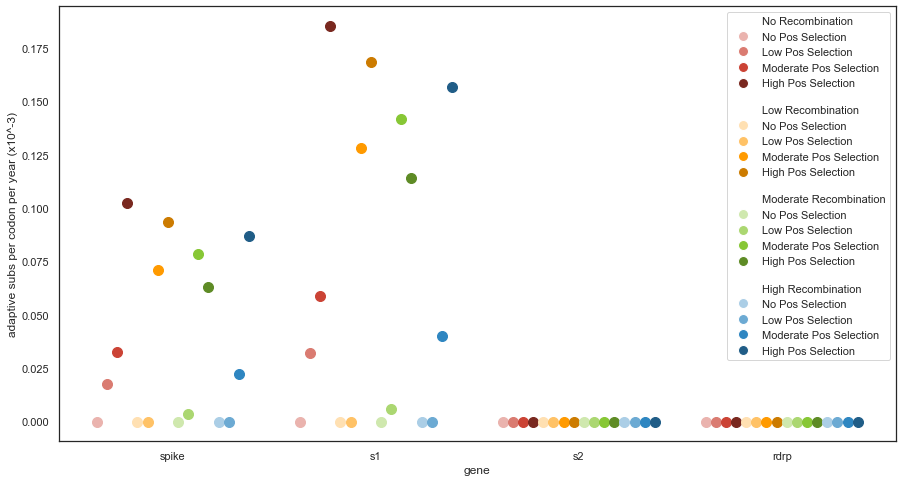

In [148]:
plot_adaptive_subs_per_codon_per_year_slope(['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 
                                             's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16'], 
                                            ['spike', 's1', 's2', 'rdrp'], filename = 'oc43a_simulations_bhatt.png')